# 6.6 Sourcing & Analyzing Time-Series Data - World Real Estate Transactions

## Content:

#### 01. Importing libraries and data
#### 02. Subsetting, wrangling, and cleaning time-series data
#### 03. Time series analysis: decomposition
#### 04. Testing for stationarity
#### 05. Stationarizing the Federal Reserve Economic Data

### 01. Importing libraries and data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [2]:
# Configure API key 
# quandl.ApiConfig.api_key = 'WEXbB4yFH5ihhz5qvKWT'

In [9]:
# Importing the Zillow "Real Estate Data" variable.

# data = quandl.get('ZILLOW/INDICATORS')
# data = quandl.get_table("ZILLOW/DATA", indicator_id='ZSFH', region_id='61223', paginate=True)

In [24]:
# folder path to main project folder
path = r'C:\Users\ThinkPad T570\Documents\05-2024 OpenData WorldRealEstate Analysis_LazerHF'

In [40]:
# importing prepared World Real Estate dataframe
df = pd.read_csv(os.path.join(path, '02 Data', 'Prepared Data', 'listings_clean.csv'), index_col=False)

In [42]:
df.head(5)

,Unnamed: 0,Title,Country,Location,Year,Total_Floors,Apart_Floors,Apart_Rooms,Total_Area,Price,Continent,C-Code,Price_category,Time_Period
0,1,"4 room apartment 245 m² in Yesiloez, Turkey",Turkey,"Yesiloez, Mediterranean Region, Alanya, Turkey",2007,2,3,5,245,274415.0,Europe,5,Middle price,2000-2010
1,4,"2 room apartment 54 m² in Prague, Czech Republic",Czech Republic,"Prague, Czech Republic",2023,4,2,4,54,314990.0,Europe,5,Middle price,2010on
2,6,"3 room apartment 72 m² in Minsk, Belarus",Belarus,"Minsk, Belarus",1955,4,4,3,72,122000.0,Europe,5,Middle price,1950-2000
3,7,"3 room apartment 100 m² in Minsk, Belarus",Belarus,"Minsk, Belarus",2013,16,2,3,100,159000.0,Europe,5,Middle price,2010on
4,16,"1 room apartment 55 m² in Akarca, Turkey",Turkey,"Akarca, Central Anatolia Region, Turkey",2021,6,2,2,55,314122.0,Europe,5,Middle price,2010on


In [28]:
df.columns

Index(['Unnamed: 0', 'Title', 'Country', 'Location', 'Year', 'Total_Floors',
       'Apart_Floors', 'Apart_Rooms', 'Total_Area', 'Price', 'Continent',
       'C-Code', 'Price_category', 'Time_Period'],
      dtype='object')

### 02. Subsetting, wrangling, and cleaning time-series data

In [52]:
# creating dataframe with time variable and sum up transaction prices
df_sub = df.groupby('Year')['Price'].sum().reset_index(name ='Total Amount')

In [53]:
df_sub.head()

,Year,Total Amount
0,1810,521726.0
1,1822,219032.0
2,1836,35632.0
3,1838,272480.0
4,1850,508674.0


In [54]:
df_sub.shape

(143, 2)

In [55]:
type(df_sub)

pandas.core.frame.DataFrame

In [50]:
# removes the index column
# df_sub.reset_index(drop=True, inplace=True)
# Reset index so that you can use the "Year" column as a filter

df_sub = df.reset_index()

In [56]:
df_sub.head()

,Year,Total Amount
0,1810,521726.0
1,1822,219032.0
2,1836,35632.0
3,1838,272480.0
4,1850,508674.0


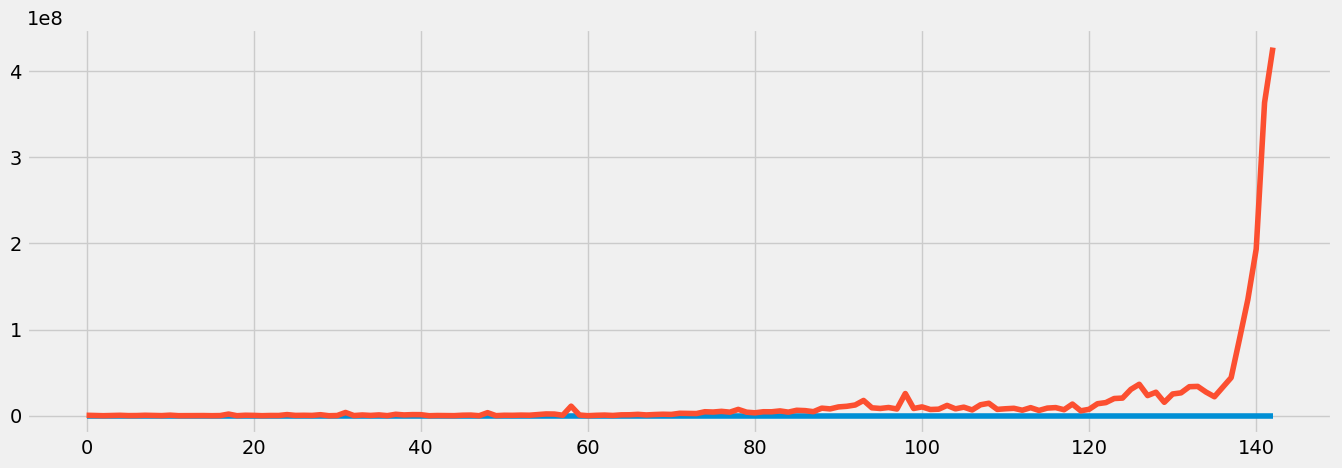

In [45]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(df_sub)

In [ ]:
# Reset index so that you can use the "Date" column as a filter
# data_2 = data.reset_index()

In [63]:
df_sub.columns

Index(['Year', 'Total Amount'], dtype='object')

In [58]:
df_sub.dtypes

Year              int64
Total Amount    float64
dtype: object

In [74]:
data_sub = df_sub.loc[(df_sub['Year'] >= 1974) & (df_sub['Year'] <= 2024)]

## Explanation for subset:
In order to focus our analysis on more recent trends in the global real estate market, I have created a subset of our dataset to include only the last 50 years of transaction records. This decision aligns with our objective to understand contemporary market dynamics and ensures our findings remain relevant and actionable. We believe this approach will provide a clearer picture of current patterns and trends, and will guide more effective decision-making in this constantly evolving industry.

In [75]:
data_sub.shape

(51, 2)

In [76]:
data_sub.head()

,Year,Total Amount
92,1974,12456173.0
93,1975,17720170.0
94,1976,9197917.0
95,1977,8432576.0
96,1978,9536831.0


In [85]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['Datetime'] = pd.to_datetime(data_sub['Year']) # Create a datetime column from "Year"
data_sub = data_sub.set_index('Datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Year'], axis=1, inplace=True) # Drop the "Year" column.
data_sub.head()

KeyError: 'Year'

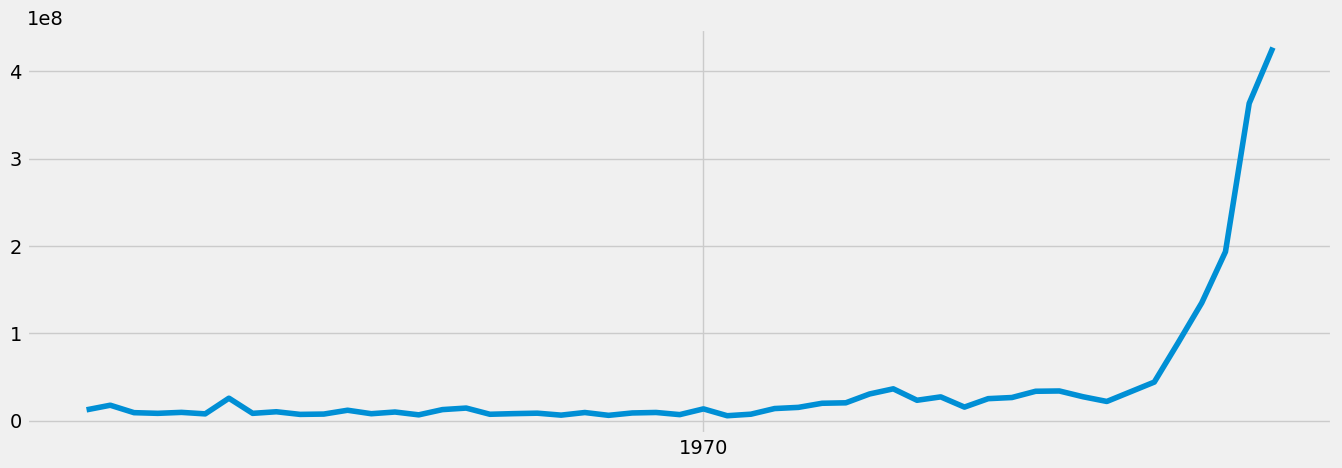

In [78]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [79]:
# Check for missing values (you shouldn't have any)

data_sub.isnull().sum() 

Total Amount    0
dtype: int64

In [80]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

# No dups!

0

### 03. Time series analysis: decomposition

In [81]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

ValueError: freq N not understood. Please report if you think this is in error.

In [82]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

In [83]:
# Plot the separate components

decomposition.plot()
plt.show()

NameError: name 'decomposition' is not defined

## Interpretation:
Decompose the data’s components.
Analyze the results from the plot in a markdown cell.

### 04. Testing for stationarity

In [84]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

KeyError: 'Value'

## Interpretation:
Conduct a Dickey-Fuller test to check for stationarity.
Interpret the results in a markdown cell and reference your null hypothesis.

In [ ]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

### 05. Stationarizing the Real Estate Transaction Data

In [ ]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [ ]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [ ]:
data_diff.head()

In [ ]:
data_diff.columns

In [ ]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [ ]:
dickey_fuller(data_diff)

In [ ]:
plot_acf(data_diff)
plt.show()